# Unit Ablation Robustness Analysis

Analyze network robustness by ablating (freezing to 0) random subsets of hidden units during inference and measuring how position decoding error degrades.

**Method**: For each ablation percentage, we randomly select units to ablate, freeze their activity to 0 during the forward pass, and measure decoding error. We resample the ablated units 5 times per percentage to get error bars.

**Ablation percentages**: 0%, 2%, 4%, 6%, 8%, 10%, 12%, 14%, 16%

In [10]:
# === IMPORTS AND CONFIGURATION ===
import os
import yaml
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple

# Add parent directory to path for imports
import sys
sys.path.insert(0, str(Path.cwd().parent))

from timescales.rnns.multitimescale_rnn import MultiTimescaleRNN
from timescales.datamodules.path_integration import PathIntegrationDataModule

# === SWEEP CONFIGURATION ===
SWEEP_DIR = Path("/home/facosta/timescales/timescales/logs/experiments/timescale_distribution_sweep_20260122_094217")

# Experiment names (same as notebook 16)
EXPERIMENT_NAMES = [
    "ReLU_discrete_1",
    "ReLU_discrete_2", 
    "ReLU_discrete_4",
    "ReLU_powerlaw",
    "Tanh_discrete_1",
    "Tanh_discrete_2",
    "Tanh_discrete_4",
    "Tanh_powerlaw",
]

# === ABLATION PARAMETERS ===
ABLATION_PERCENTAGES = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16]  # % of units to ablate
NUM_RESAMPLES = 10  # Number of random ablation samples per percentage
NUM_TEST_TRAJECTORIES = 200  # Number of trajectories for evaluation (speed vs accuracy)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(f"Sweep directory: {SWEEP_DIR}")
print(f"Ablation percentages: {ABLATION_PERCENTAGES}")
print(f"Resamples per percentage: {NUM_RESAMPLES}")

Using device: cuda
Sweep directory: /home/facosta/timescales/timescales/logs/experiments/timescale_distribution_sweep_20260122_094217
Ablation percentages: [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16]
Resamples per percentage: 10


## Helper Functions

In [11]:
def forward_with_ablation(
    model: MultiTimescaleRNN,
    inputs: torch.Tensor,
    init_context: torch.Tensor,
    ablate_indices: np.ndarray,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Forward pass with ablated (zeroed) hidden units.
    
    Args:
        model: The MultiTimescaleRNN model
        inputs: Input tensor (batch, time, input_size)
        init_context: Initial context for hidden state (batch, output_size)
        ablate_indices: Indices of hidden units to ablate (set to 0)
        
    Returns:
        hidden_states: (batch, time, hidden_size)
        outputs: (batch, time, output_size)
    """
    batch_size, seq_len, _ = inputs.shape
    
    # Initialize hidden state
    hidden_states = []
    outputs = []
    hidden = model.W_h_init(init_context)
    
    # Ablate initial hidden state
    if len(ablate_indices) > 0:
        hidden[:, ablate_indices] = 0
    
    for t in range(seq_len):
        input_t = inputs[:, t, :]
        hidden = model.rnn_step(input_t, hidden)
        
        # Ablate: set selected units to 0 after each step
        if len(ablate_indices) > 0:
            hidden[:, ablate_indices] = 0
        
        hidden_states.append(hidden)
        outputs.append(model.W_out(hidden))
    
    return torch.stack(hidden_states, dim=1), torch.stack(outputs, dim=1)


def compute_decoding_error(
    model: MultiTimescaleRNN,
    datamodule: PathIntegrationDataModule,
    ablate_indices: np.ndarray,
    device: str,
) -> float:
    """
    Compute mean position decoding error with ablated units.
    
    Args:
        model: The trained model
        datamodule: DataModule with test trajectories
        ablate_indices: Indices of units to ablate
        device: Device to run on
        
    Returns:
        Mean decoding error in meters
    """
    model.eval()
    place_cell_centers = datamodule.place_cell_centers.to(device)
    
    all_errors = []
    with torch.no_grad():
        for batch in datamodule.val_dataloader():
            inputs, positions, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            positions = positions.to(device)
            
            # Forward pass with ablation
            _, outputs = forward_with_ablation(
                model, inputs, targets[:, 0, :], ablate_indices
            )
            
            # Decode position: argmax over place cells, then lookup position
            pred_probs = torch.softmax(outputs, dim=-1)
            pred_idx = pred_probs.argmax(dim=-1)  # (batch, time)
            pred_positions = place_cell_centers[pred_idx]  # (batch, time, 2)
            
            # Compute Euclidean error
            error = torch.sqrt(((positions - pred_positions) ** 2).sum(-1))
            all_errors.append(error.mean().item())
    
    return np.mean(all_errors)


def evaluate_with_ablation(
    model: MultiTimescaleRNN,
    datamodule: PathIntegrationDataModule,
    ablation_fraction: float,
    device: str,
    num_resamples: int = 5,
) -> Tuple[float, float]:
    """
    Evaluate model with random unit ablation.
    
    Args:
        model: The trained model
        datamodule: DataModule with test trajectories  
        ablation_fraction: Fraction of units to ablate (0.0 to 1.0)
        device: Device to run on
        num_resamples: Number of random ablation samples
        
    Returns:
        (mean_error, std_error) across resamples
    """
    hidden_size = model.hidden_size
    num_ablate = int(hidden_size * ablation_fraction)
    
    errors = []
    for _ in range(num_resamples):
        # Random ablation mask (different each resample)
        if num_ablate > 0:
            ablate_indices = np.random.choice(hidden_size, num_ablate, replace=False)
        else:
            ablate_indices = np.array([], dtype=int)
        
        # Compute decoding error with this ablation
        error = compute_decoding_error(model, datamodule, ablate_indices, device)
        errors.append(error)
    
    return np.mean(errors), np.std(errors)

In [12]:
def load_model_and_datamodule(
    sweep_dir: Path,
    exp_name: str,
    seed: int = 0,
    device: str = "cuda",
    num_trajectories: int = 200,
) -> Tuple[MultiTimescaleRNN, PathIntegrationDataModule, dict]:
    """
    Load a trained model and create a datamodule for evaluation.
    
    Returns:
        model, datamodule, config
    """
    exp_path = sweep_dir / exp_name / f"seed_{seed}"
    
    # Load config
    config_path = exp_path / f"config_seed{seed}.yaml"
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    
    # Get activation function
    activation_name = config.get("activation", "ReLU")
    activation_cls = getattr(nn, activation_name)
    
    # Extract timescale config
    ts_config = config.get("timescales_config", {})
    
    # Load model
    model_path = exp_path / f"final_model_seed{seed}.pth"
    model = MultiTimescaleRNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["num_place_cells"],
        dt=config["dt"],
        timescales_config=ts_config,
        activation=activation_cls,
        learn_timescales=config.get("learn_timescales", False),
        zero_diag_wrec=config.get("zero_diag_wrec", True),
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # Load place cell centers
    place_cell_centers_path = exp_path / f"place_cell_centers_seed{seed}.pt"
    place_cell_centers = torch.load(place_cell_centers_path, map_location=device)
    
    # Create datamodule
    datamodule = PathIntegrationDataModule(
        trajectory_type=config.get("trajectory_type", "ornstein_uhlenbeck"),
        velocity_representation=config.get("velocity_representation", "polar"),
        dt=config["dt"],
        num_time_steps=config["num_time_steps"],
        arena_size=config["arena_size"],
        num_place_cells=config["num_place_cells"],
        place_cell_rf=config["place_cell_rf"],
        DoG=config.get("DoG", True),
        surround_scale=config.get("surround_scale", 2),
        place_cell_layout=config.get("place_cell_layout", "random"),
        behavioral_timescale_mean=config["behavioral_timescale_mean"],
        behavioral_timescale_std=config["behavioral_timescale_std"],
        linear_speed_tau=config.get("linear_speed_tau", 1.0),
        angular_speed_mean=config.get("angular_speed_mean", 0.0),
        angular_speed_std=config.get("angular_speed_std", 1.0),
        angular_speed_tau=config.get("angular_speed_tau", 0.4),
        num_trajectories=num_trajectories,
        batch_size=64,
        num_workers=4,
        train_val_split=0.0,  # All data for evaluation
    )
    
    # Set place cell centers before setup
    datamodule.place_cell_centers = place_cell_centers
    datamodule.setup()
    
    return model, datamodule, config


## Run Ablation Analysis


In [13]:
# Run ablation analysis for all experiments
all_ablation_results = {}

for exp_name in EXPERIMENT_NAMES:
    print(f"\n{'='*60}")
    print(f"Ablation Analysis: {exp_name}")
    print('='*60)
    
    try:
        # Load model and datamodule
        model, datamodule, config = load_model_and_datamodule(
            sweep_dir=SWEEP_DIR,
            exp_name=exp_name,
            device=device,
            num_trajectories=NUM_TEST_TRAJECTORIES,
        )
        
        hidden_size = model.hidden_size
        print(f"  Hidden size: {hidden_size}")
        
        # Evaluate at each ablation percentage
        means = []
        stds = []
        
        for pct in ABLATION_PERCENTAGES:
            fraction = pct / 100.0
            num_ablate = int(hidden_size * fraction)
            
            mean_err, std_err = evaluate_with_ablation(
                model=model,
                datamodule=datamodule,
                ablation_fraction=fraction,
                device=device,
                num_resamples=NUM_RESAMPLES,
            )
            
            means.append(mean_err)
            stds.append(std_err)
            
            print(f"  {pct:2d}% ablated ({num_ablate:3d} units): error = {mean_err:.4f} +/- {std_err:.4f} m")
        
        all_ablation_results[exp_name] = {
            "percentages": ABLATION_PERCENTAGES,
            "means": np.array(means),
            "stds": np.array(stds),
            "hidden_size": hidden_size,
        }
        
    except Exception as e:
        print(f"  ERROR: {e}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*60}")
print(f"Ablation analysis complete for {len(all_ablation_results)} experiments")
print('='*60)



Ablation Analysis: ReLU_discrete_1
Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s
  Hidden size: 256
   0% ablated (  0 units): error = 0.0464 +/- 0.0000 m
   1% ablated (  2 units): error = 0.0967 +/- 0.0156 m
   2% ablated (  5 units): error = 0.1557 +/- 0.0287 m
   3% ablated (  7 units): error = 0.1887 +/- 0.0666 m
   4% ablated ( 10 units): error = 0.2269 +/- 0.0611 m
   5% ablated ( 12 units): error = 0.2752 +/- 0.0597 m
   6% ablated ( 15 units): error = 0.2797 +/- 0.0593 m
   8% ablated ( 20 units): error = 0.3333 +/- 0.0479 m
  10% ablated ( 25 units): error = 0.3636 +/- 0.0668 m
  12% ablated ( 30 units): error = 0.4042 +/- 0.0244 m
  14% ablated ( 35 units): error = 0.4081 +/- 0.0445 m
  16% ablated ( 40 units): error = 0.4543 +/- 0.0502 m

Ablation Analysis: ReLU_discrete_2
Behavioral timescale parameterization:
  τ_behavior: mean=0.600s, std=0.000s
  → linear_speed: mean=0.333m/s, std=0.000m/s
  H

## Visualization

Plot decoding error vs ablation percentage for all networks.


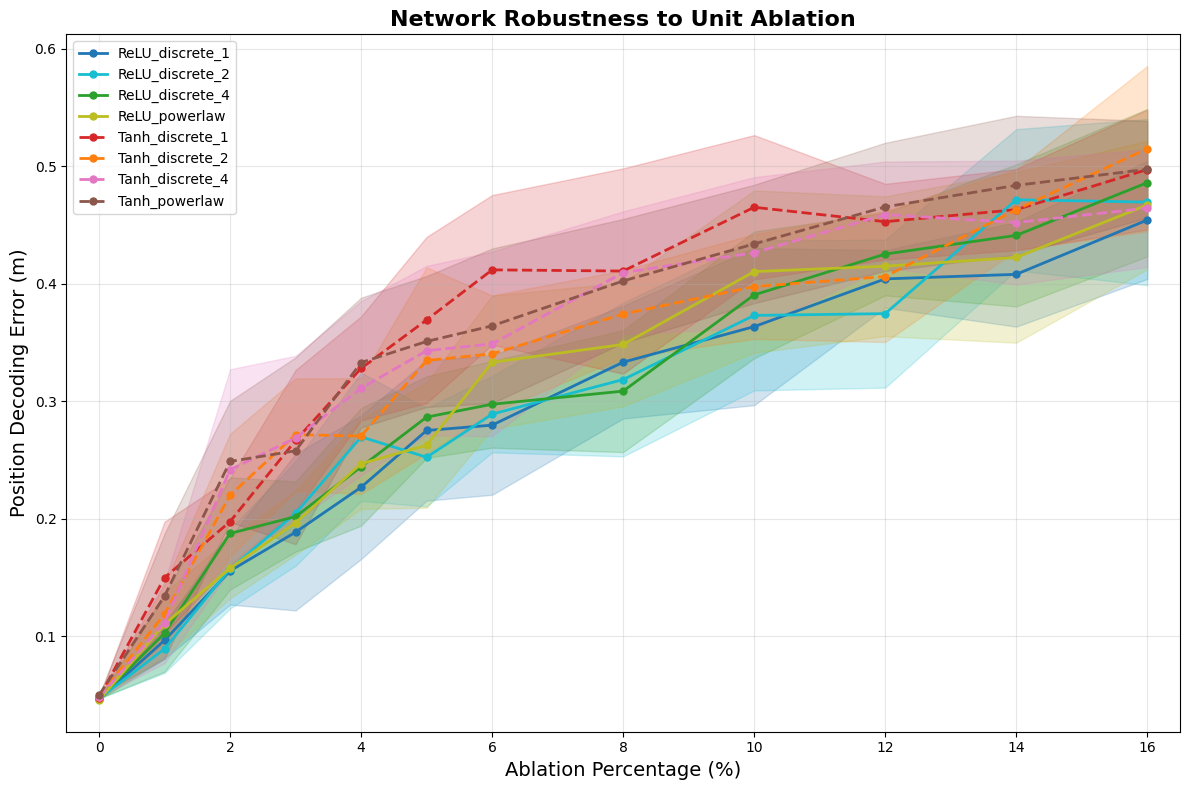

In [14]:
# Plot ablation robustness for all experiments
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Color scheme: different colors for each experiment
colors = {
    "ReLU_discrete_1": "tab:blue",
    "ReLU_discrete_2": "tab:cyan",
    "ReLU_discrete_4": "tab:green",
    "ReLU_powerlaw": "tab:olive",
    "Tanh_discrete_1": "tab:red",
    "Tanh_discrete_2": "tab:orange",
    "Tanh_discrete_4": "tab:pink",
    "Tanh_powerlaw": "tab:brown",
}

# Linestyles: solid for ReLU, dashed for Tanh
linestyles = {name: "-" if "ReLU" in name else "--" for name in EXPERIMENT_NAMES}

for exp_name, results in all_ablation_results.items():
    pcts = results["percentages"]
    means = results["means"]
    stds = results["stds"]
    color = colors.get(exp_name, "gray")
    ls = linestyles.get(exp_name, "-")
    
    # Plot mean with error bars (shaded region)
    ax.fill_between(pcts, means - stds, means + stds, alpha=0.2, color=color)
    ax.plot(pcts, means, color=color, linestyle=ls, linewidth=2, 
            label=exp_name, marker="o", markersize=5)

ax.set_xlabel("Ablation Percentage (%)", fontsize=14)
ax.set_ylabel("Position Decoding Error (m)", fontsize=14)
ax.set_title("Network Robustness to Unit Ablation", fontsize=16, fontweight="bold")
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.5, max(ABLATION_PERCENTAGES) + 0.5])

plt.tight_layout()
#plt.savefig(SWEEP_DIR / "ablation_robustness.png", dpi=150, bbox_inches="tight")
plt.show()


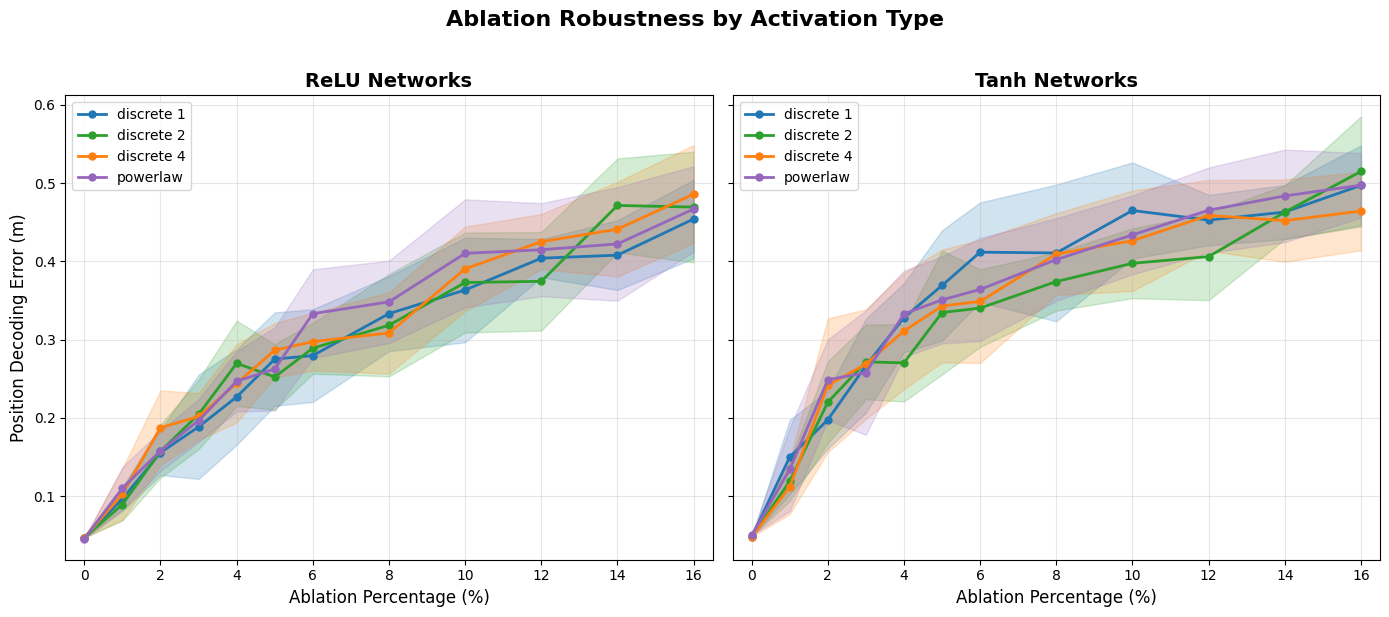

In [15]:
# Split plot: ReLU vs Tanh side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Separate by activation
relu_exps = [name for name in EXPERIMENT_NAMES if "ReLU" in name]
tanh_exps = [name for name in EXPERIMENT_NAMES if "Tanh" in name]

# Colors for timescale distributions within each activation
ts_colors = {
    "discrete_1": "tab:blue",
    "discrete_2": "tab:green", 
    "discrete_4": "tab:orange",
    "powerlaw": "tab:purple",
}

def get_ts_type(name):
    if "discrete_1" in name:
        return "discrete_1"
    elif "discrete_2" in name:
        return "discrete_2"
    elif "discrete_4" in name:
        return "discrete_4"
    else:
        return "powerlaw"

# Plot ReLU
ax = axes[0]
for exp_name in relu_exps:
    if exp_name not in all_ablation_results:
        continue
    results = all_ablation_results[exp_name]
    pcts = results["percentages"]
    means = results["means"]
    stds = results["stds"]
    ts_type = get_ts_type(exp_name)
    color = ts_colors[ts_type]
    
    ax.fill_between(pcts, means - stds, means + stds, alpha=0.2, color=color)
    ax.plot(pcts, means, color=color, linewidth=2, label=ts_type.replace("_", " "), 
            marker="o", markersize=5)

ax.set_xlabel("Ablation Percentage (%)", fontsize=12)
ax.set_ylabel("Position Decoding Error (m)", fontsize=12)
ax.set_title("ReLU Networks", fontsize=14, fontweight="bold")
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.5, max(ABLATION_PERCENTAGES) + 0.5])

# Plot Tanh
ax = axes[1]
for exp_name in tanh_exps:
    if exp_name not in all_ablation_results:
        continue
    results = all_ablation_results[exp_name]
    pcts = results["percentages"]
    means = results["means"]
    stds = results["stds"]
    ts_type = get_ts_type(exp_name)
    color = ts_colors[ts_type]
    
    ax.fill_between(pcts, means - stds, means + stds, alpha=0.2, color=color)
    ax.plot(pcts, means, color=color, linewidth=2, label=ts_type.replace("_", " "),
            marker="o", markersize=5)

ax.set_xlabel("Ablation Percentage (%)", fontsize=12)
ax.set_title("Tanh Networks", fontsize=14, fontweight="bold")
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.5, max(ABLATION_PERCENTAGES) + 0.5])

plt.suptitle("Ablation Robustness by Activation Type", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
#plt.savefig(SWEEP_DIR / "ablation_robustness_split.png", dpi=150, bbox_inches="tight")
plt.show()


## Summary Statistics

Compute robustness metrics: slope of error increase and error at 10% ablation.


In [16]:
# Compute robustness metrics
print("Ablation Robustness Summary")
print("="*80)
print(f"{'Experiment':<25} {'Baseline Error':<15} {'Error @ 10%':<15} {'Slope':<12} {'Relative @ 10%'}")
print("-"*80)

for exp_name, results in sorted(all_ablation_results.items()):
    pcts = np.array(results["percentages"])
    means = results["means"]
    
    # Baseline (0% ablation)
    baseline = means[0]
    
    # Error at 10% ablation (interpolate if needed)
    idx_10 = np.where(pcts == 10)[0]
    if len(idx_10) > 0:
        err_10 = means[idx_10[0]]
    else:
        err_10 = np.nan
    
    # Linear slope (error per percentage point)
    slope, _ = np.polyfit(pcts, means, 1)
    
    # Relative increase at 10%
    rel_increase = (err_10 / baseline - 1) * 100 if baseline > 0 else np.nan
    
    print(f"{exp_name:<25} {baseline:<15.4f} {err_10:<15.4f} {slope:<12.5f} {rel_increase:>8.1f}%")

print("-"*80)
print("\nInterpretation:")
print("  - Lower slope = more robust to ablation")
print("  - Lower relative increase @ 10% = more distributed representations")


Ablation Robustness Summary
Experiment                Baseline Error  Error @ 10%     Slope        Relative @ 10%
--------------------------------------------------------------------------------
ReLU_discrete_1           0.0464          0.3636          0.02383         683.6%
ReLU_discrete_2           0.0471          0.3731          0.02495         692.4%
ReLU_discrete_4           0.0472          0.3906          0.02508         727.7%
ReLU_powerlaw             0.0458          0.4104          0.02468         795.6%
Tanh_discrete_1           0.0480          0.4651          0.02425         870.0%
Tanh_discrete_2           0.0486          0.3976          0.02417         717.7%
Tanh_discrete_4           0.0481          0.4265          0.02314         786.8%
Tanh_powerlaw             0.0500          0.4339          0.02434         768.5%
--------------------------------------------------------------------------------

Interpretation:
  - Lower slope = more robust to ablation
  - Lower relativ